In [1]:
import os
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Define dataset path (Only two categories: Healthy & Scorched)
dataset_path = "../CNNExpirement/dataset"
target_categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

# ✅ Define image size and batch size
IMG_SIZE = (224, 224)
PATCH_SIZE = 16  # Patch size for ViT
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary classification

# ✅ ImageDataGenerator with STRONGER Augmentations
datagen = ImageDataGenerator(
    rescale=1./255, validation_split=0.2,
    rotation_range=30, zoom_range=0.3, horizontal_flip=True,
    brightness_range=[0.8, 1.2], shear_range=10
)

# ✅ Load training & validation data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    classes=target_categories
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=True,
    classes=target_categories
)

# ✅ Compute class weights to balance training
labels = train_generator.classes
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("🔢 Computed Class Weights:", class_weights_dict)

2025-03-11 15:04:29.544686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1038 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
🔢 Computed Class Weights: {0: 3.4832214765100673, 1: 0.5838020247469067}


In [2]:
# ✅ Improved Vision Transformer Model
def create_vit_classifier(img_size=224, patch_size=16, num_classes=1, projection_dim=64, num_heads=4, transformer_layers=6):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Patch embedding
    num_patches = (img_size // patch_size) ** 2
    patch_embedding = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patch_embedding = layers.Reshape((num_patches, projection_dim))(patch_embedding)
    
    # Add class token
    class_token = layers.Dense(projection_dim, activation="relu")(tf.zeros((1, 1, projection_dim)))
    class_tokens = tf.tile(class_token, [tf.shape(inputs)[0], 1, 1])
    x = layers.Concatenate(axis=1)([class_tokens, patch_embedding])

    # Positional encoding
    pos_encoding = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(tf.range(num_patches + 1))
    x += pos_encoding

    # Transformer Encoder Blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization()(x)
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([x, x1])
        
        x3 = layers.LayerNormalization()(x2)
        x3 = layers.Dense(projection_dim * 4, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        x = layers.Add()([x2, x3])

    # Classification head
    x = layers.LayerNormalization()(x[:, 0, :])  # Use class token
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    
    return models.Model(inputs, outputs)

# ✅ Build ViT model
model = create_vit_classifier()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slower LR
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ✅ Early Stopping & Reduce LR (Prevents Overfitting)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# ✅ Train Model
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increased epochs but will stop early if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)
end_time = time.time()

print(f"✅ Training completed in {end_time - start_time:.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

2025-03-11 15:04:36.235661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
65/65 [==============================] - 44s 541ms/step - loss: 0.7533 - accuracy: 0.4913 - val_loss: 0.6066 - val_accuracy: 0.8571 - lr: 5.0000e-04
Epoch 2/30
65/65 [==============================] - 36s 549ms/step - loss: 0.7182 - accuracy: 0.5289 - val_loss: 0.6590 - val_accuracy: 0.8069 - lr: 5.0000e-04
Epoch 3/30
65/65 [==============================] - 36s 546ms/step - loss: 0.7059 - accuracy: 0.5568 - val_loss: 1.1178 - val_accuracy: 0.1429 - lr: 5.0000e-04
Epoch 4/30
65/65 [==============================] - 35s 545ms/step - loss: 0.5746 - accuracy: 0.7062 - val_loss: 0.2935 - val_accuracy: 0.8803 - lr: 5.0000e-04
Epoch 5/30
65/65 [==============================] - 35s 542ms/step - loss: 0.5029 - accuracy: 0.7977 - val_loss: 0.9045 - val_accuracy: 0.1660 - lr: 5.0000e-04
Epoch 6/30
65/65 [==============================] - 37s 571ms/step - loss: 0.3731 - accuracy: 0.8410 - val_loss: 0.6445 - val_accuracy: 0.7838 - lr: 5.0000e-04
Epoch 7/30
65/65 [======================

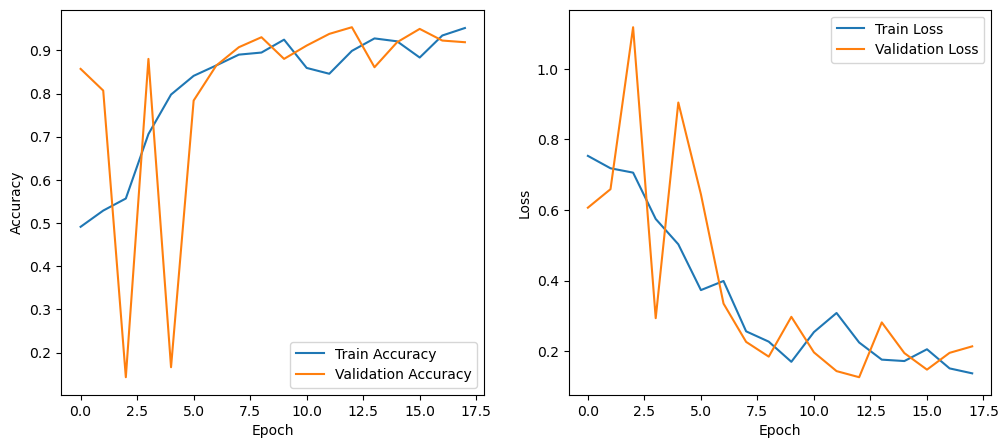

In [3]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [4]:
import random 
from tensorflow.keras.preprocessing import image

# ✅ Function to get a truly random image
def get_random_image():
    """Selects a random image from the dataset (healthy/unhealthy)."""
    category = random.choice(target_categories)  # Pick a random category
    category_path = os.path.join(dataset_path, category)

    images = [f for f in os.listdir(category_path) if f.lower().endswith('.jpg')]
    if not images:
        return None  # If no images exist, return None
    
    random.shuffle(images)  # Shuffle to ensure randomness
    random_image = random.choice(images)  # Pick a truly random image
    return os.path.join(category_path, random_image)

# ✅ Function to predict an image and display results
def predict_image(img_path):
    img_name = os.path.basename(img_path)  # Extract image name

    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

    # Make prediction
    prediction = model.predict(img_array)[0][0]  # Get single prediction value

    # Determine class based on threshold
    label = "Unhealthy" if prediction > 0.5 else "Healthy"

    # Print results
    print(f"🖼️ Image: {img_name}")
    print(f"🔍 Prediction Value: {prediction:.4f}")
    print(f"✅ Class: {label}")

    # Show the image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{img_name}\n{label} ({prediction:.4f})")
    plt.show()

1/1 [==============================] - 1s 856ms/step
🖼️ Image: 5c7bf62d-3c64-4738-8378-d530b9f73cc1___RS_HL 4517.JPG
🔍 Prediction Value: 0.0442
✅ Class: Healthy


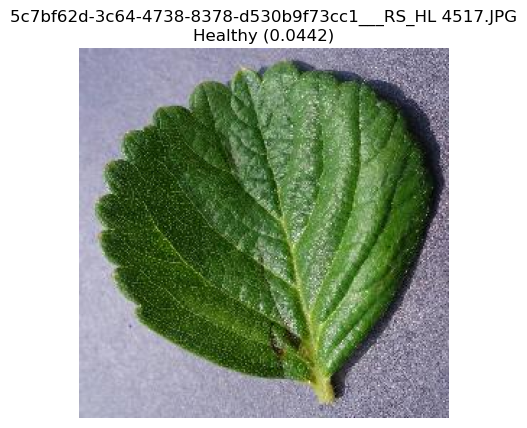

1/1 [==============================] - 0s 47ms/step
🖼️ Image: 60646de2-333f-40b6-bdf9-f0d1d0e91271___RS_HL 4795.JPG
🔍 Prediction Value: 0.0300
✅ Class: Healthy


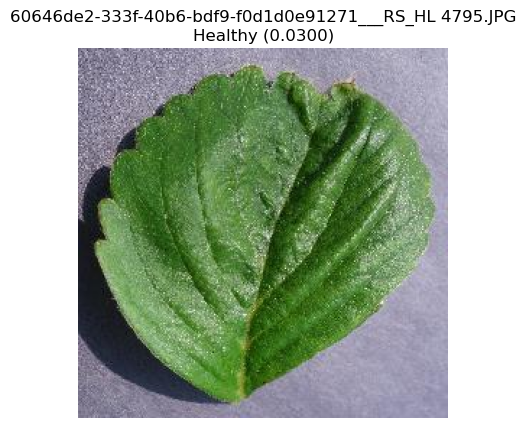

1/1 [==============================] - 0s 56ms/step
🖼️ Image: 1b9a47df-830d-4c52-b7e0-3180c8fee141___RS_HL 4482.JPG
🔍 Prediction Value: 0.0689
✅ Class: Healthy


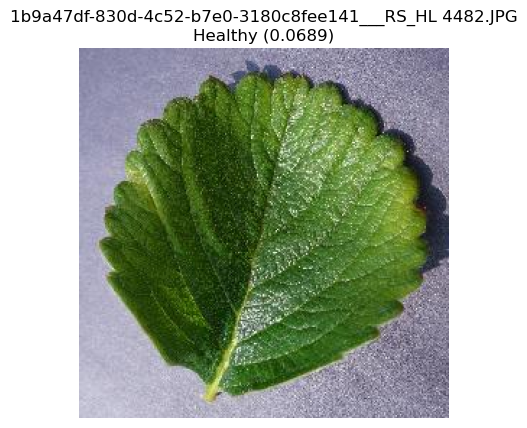

1/1 [==============================] - 0s 44ms/step
🖼️ Image: 7cf5daf3-540a-4451-bbad-3721d2290c1c___RS_L.Scorch 0830.JPG
🔍 Prediction Value: 0.9871
✅ Class: Unhealthy


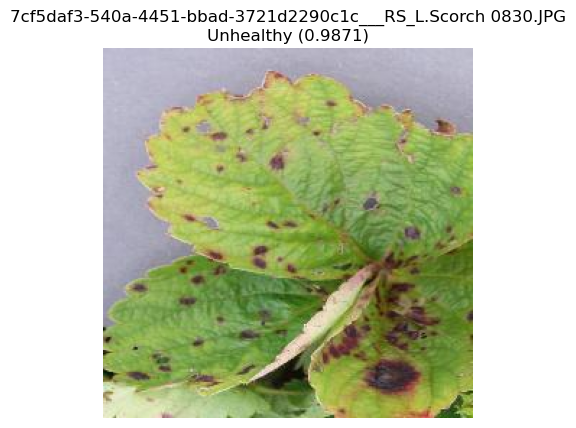

1/1 [==============================] - 0s 45ms/step
🖼️ Image: 335c0d85-bf45-4cd0-9135-81447bab4ff9___RS_HL 1944.JPG
🔍 Prediction Value: 0.1116
✅ Class: Healthy


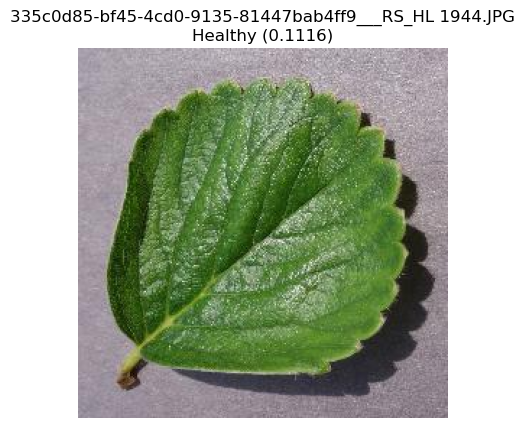

1/1 [==============================] - 0s 46ms/step
🖼️ Image: 23af7051-346c-4eac-b8d0-9d22b6690842___RS_L.Scorch 0944.JPG
🔍 Prediction Value: 0.9911
✅ Class: Unhealthy


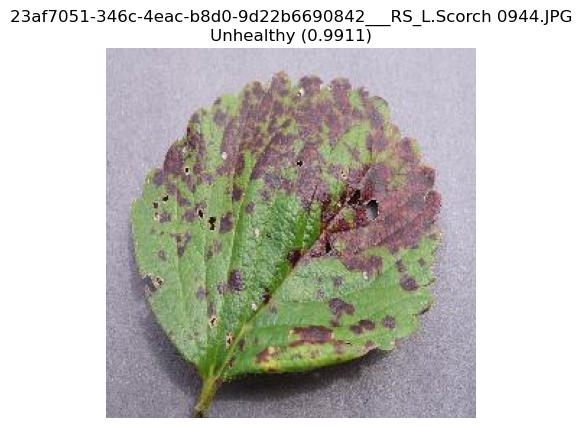

1/1 [==============================] - 0s 45ms/step
🖼️ Image: c76aba29-28a3-43d4-949f-ea8b75f9c8f3___RS_L.Scorch 0087.JPG
🔍 Prediction Value: 0.9920
✅ Class: Unhealthy


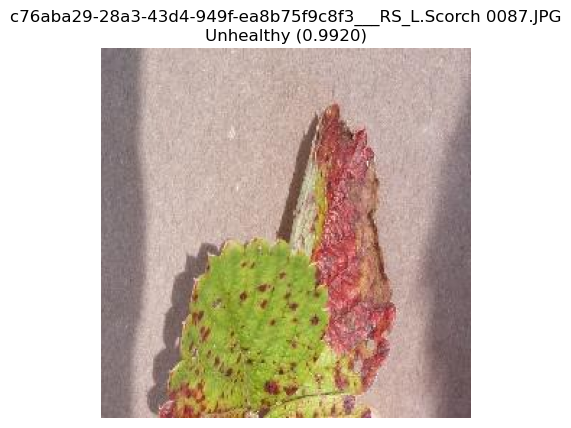

1/1 [==============================] - 0s 44ms/step
🖼️ Image: a2461220-5917-47c9-ac37-5432dfaec05b___RS_L.Scorch 0858.JPG
🔍 Prediction Value: 0.9920
✅ Class: Unhealthy


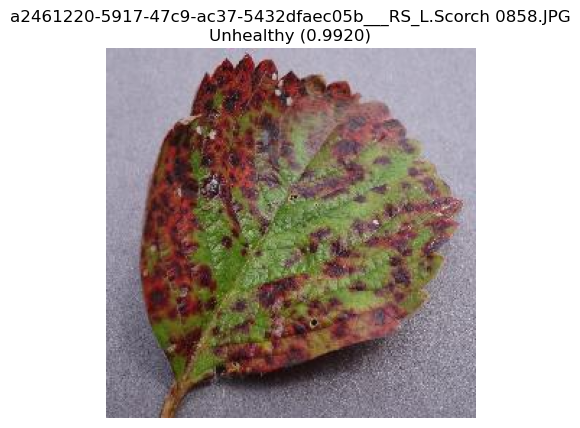

1/1 [==============================] - 0s 45ms/step
🖼️ Image: bf6d0b94-c850-473c-8725-fddf57f19ac5___RS_L.Scorch 1142.JPG
🔍 Prediction Value: 0.9912
✅ Class: Unhealthy


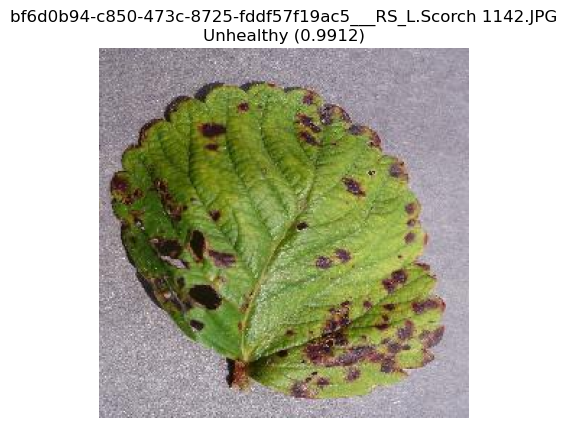

1/1 [==============================] - 0s 57ms/step
🖼️ Image: 5879315d-20ab-4f95-8a38-3459fd973d5a___RS_L.Scorch 1208.JPG
🔍 Prediction Value: 0.9886
✅ Class: Unhealthy


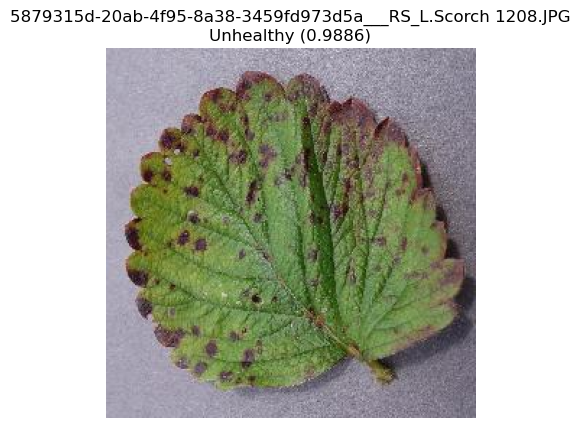

1/1 [==============================] - 0s 60ms/step
🖼️ Image: bc12a3b9-5bf2-478c-96e3-78876119b5aa___RS_L.Scorch 1146.JPG
🔍 Prediction Value: 0.9914
✅ Class: Unhealthy


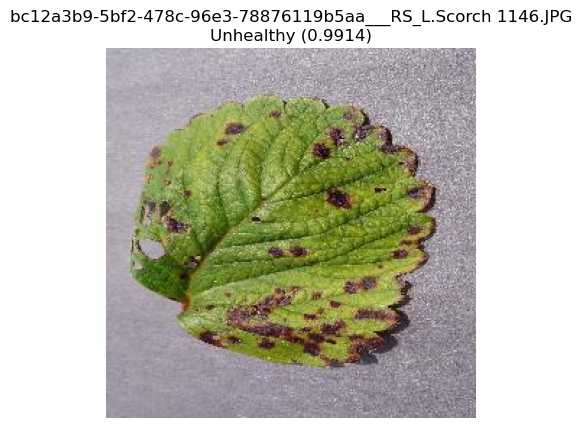

1/1 [==============================] - 0s 53ms/step
🖼️ Image: 4c3cc96f-e1d9-4237-b72d-2a1ea0a755f8___RS_HL 2167.JPG
🔍 Prediction Value: 0.9755
✅ Class: Unhealthy


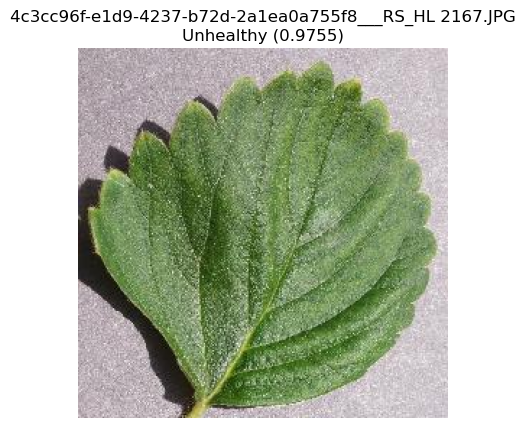

1/1 [==============================] - 0s 51ms/step
🖼️ Image: 50eb9d31-53f5-4040-b83f-681da8a8f621___RS_HL 1815.JPG
🔍 Prediction Value: 0.8950
✅ Class: Unhealthy


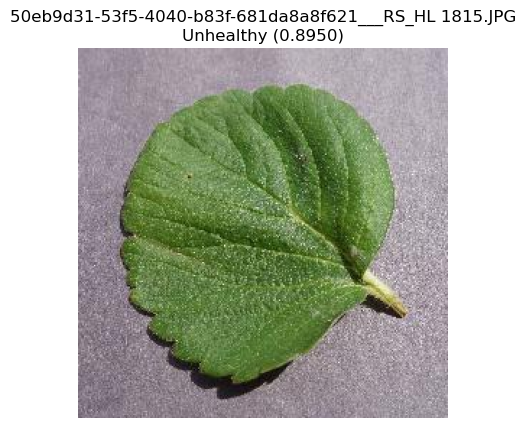

1/1 [==============================] - 0s 72ms/step
🖼️ Image: 60e9ea3a-fc7a-44ba-8875-1917ac056e5c___RS_HL 4381.JPG
🔍 Prediction Value: 0.0200
✅ Class: Healthy


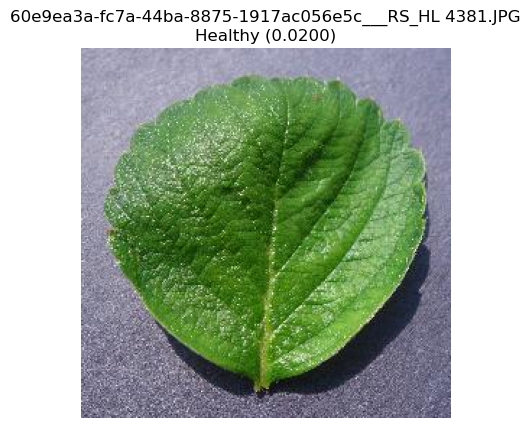

1/1 [==============================] - 0s 60ms/step
🖼️ Image: 62229adb-1069-4622-8474-7468c668ca16___RS_HL 1637.JPG
🔍 Prediction Value: 0.5645
✅ Class: Unhealthy


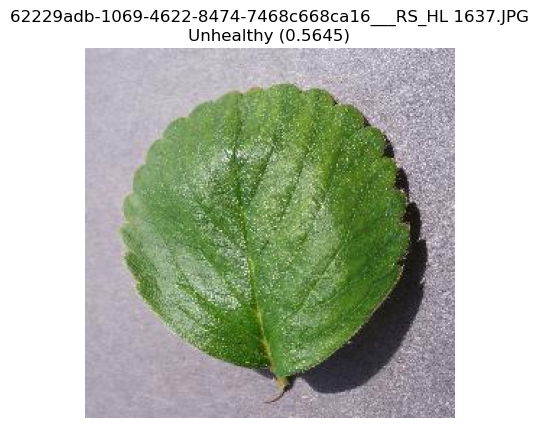

1/1 [==============================] - 0s 75ms/step
🖼️ Image: 69d26083-0e91-49a8-990b-1256dce1fdda___RS_HL 1725.JPG
🔍 Prediction Value: 0.1335
✅ Class: Healthy


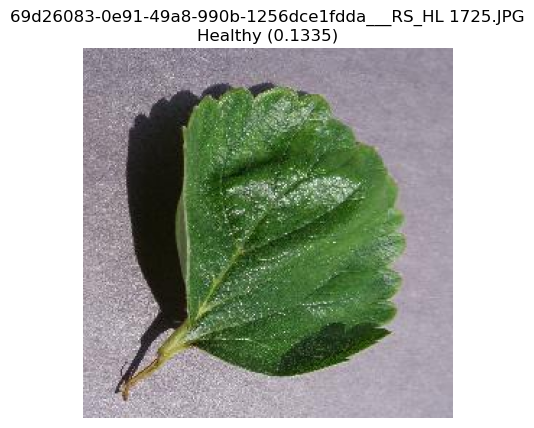

1/1 [==============================] - 0s 71ms/step
🖼️ Image: 38292ca8-c7fe-4ba5-837f-c98c714ab099___RS_HL 4608.JPG
🔍 Prediction Value: 0.0458
✅ Class: Healthy


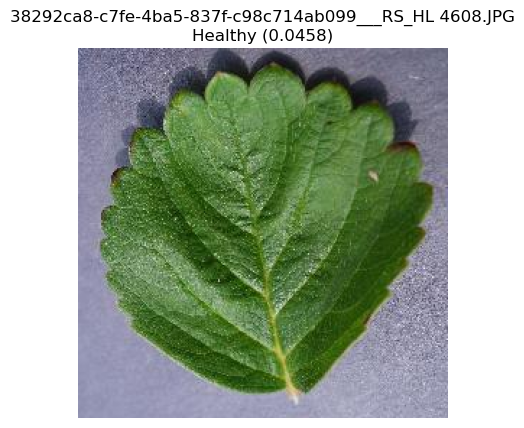

1/1 [==============================] - 0s 64ms/step
🖼️ Image: 670e9f1b-0863-4ae9-b95e-e68f6899a4f5___RS_L.Scorch 0121.JPG
🔍 Prediction Value: 0.9918
✅ Class: Unhealthy


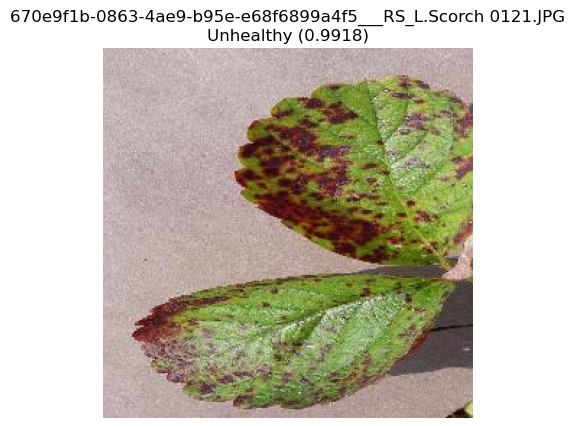

1/1 [==============================] - 0s 53ms/step
🖼️ Image: 328cd6a7-46a5-4beb-8b62-b68db500a830___RS_HL 1908.JPG
🔍 Prediction Value: 0.3841
✅ Class: Healthy


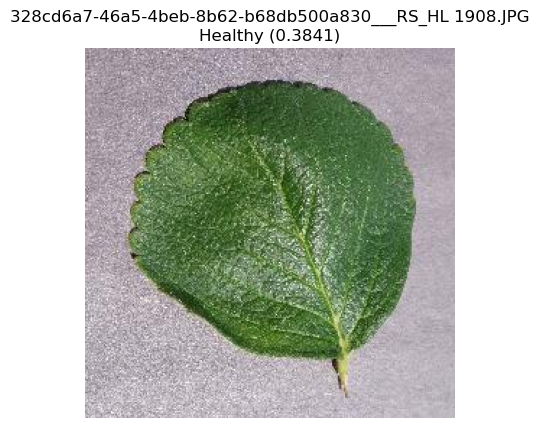

1/1 [==============================] - 0s 60ms/step
🖼️ Image: f096d5a6-5e59-46ed-a05a-e77bb0eeb176___RS_L.Scorch 1238.JPG
🔍 Prediction Value: 0.5055
✅ Class: Unhealthy


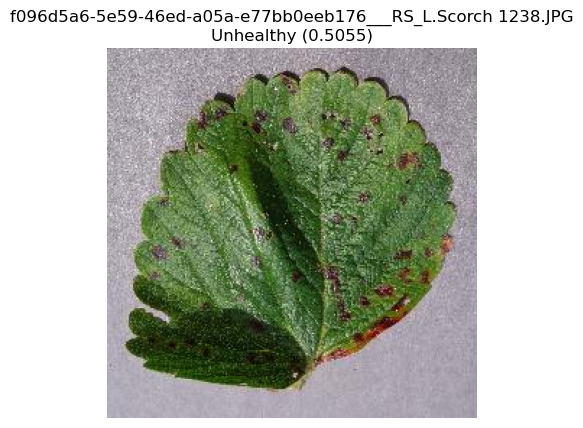

In [5]:
# ✅ Run multiple predictions
tests = 20
for _ in range(tests):
    img_path = get_random_image()
    if img_path:
        predict_image(img_path)